In [2]:
from pytc2.sistemas_lineales import plot_plantilla
import pytc2.filtros_digitales

import pytc2

import numpy as np
from scipy import signal as sig
from scipy import interpolate

import matplotlib.pyplot as plt
   
import scipy.io as sio
from scipy.io.wavfile import write

def vertical_flaten(a):

    return a.reshape(a.shape[0],1)

In [3]:
#%% Señal ECG

fs_ecg = 1000 # Hz

##################
## ECG con ruido
##################x

#para listar las variables que hay en el archivo
sio.whosmat('ECG_TP4.mat')
mat_struct = sio.loadmat('./ECG_TP4.mat')

ecg_one_lead = mat_struct['ecg_lead'].flatten()

# plt.figure(1)
# plt.plot(ecg_one_lead[5000:12000])
# plt.show()

##################
## ECG sin ruido
##################

# Variables
qrs_pattern = mat_struct['qrs_pattern1'].flatten()
heartbeat_normal = mat_struct['heartbeat_pattern1'].flatten()
heartbeat_ventricular = mat_struct['heartbeat_pattern2'].flatten()
qrs_det = mat_struct['qrs_detections'].flatten()

N = len(ecg_one_lead)

ecg_one_lead = ecg_one_lead / np.std(ecg_one_lead)
ecg_signal = ecg_one_lead / np.std(ecg_one_lead)
heartbeat_normal = heartbeat_normal / np.std(heartbeat_normal)
heartbeat_ventricular = heartbeat_ventricular / np.std(heartbeat_ventricular)
qrs_pattern = qrs_pattern / np.std(qrs_pattern)

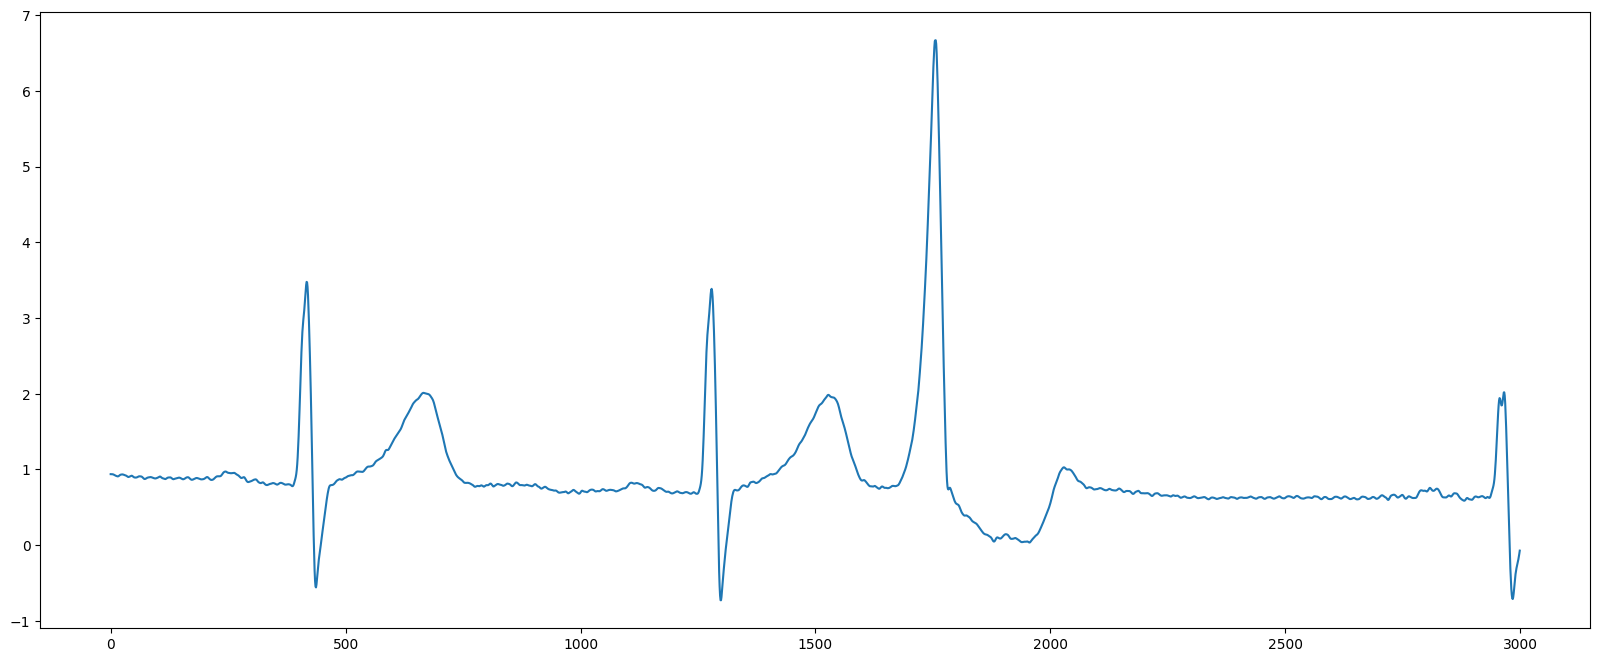

In [37]:
plt.figure(figsize=(20,8))
plt.plot(ecg_signal[140000:143000])
plt.show()

## Filtro de mediana

In [4]:
from scipy.signal import medfilt

#venetanas

win1_samples = 200
win2_samples = 600

#Paridad. Si es par le sumo 1
if win1_samples % 2 == 0:
    win1_samples += 1
if win2_samples % 2 == 0:
    win2_samples += qrs_pattern
    
#Primer filtro mediana
ecg_med1 = medfilt(ecg_signal, kernel_size = win1_samples)

#Segundo filtro de mediana
ecg_med2 = medfilt(ecg_med1, kernel_size = win1_samples)

ecg_filt_med = ecg_signal - ecg_med2


Mediana - primeros valores de x̂ (filtrada), s (original) y b̂ (línea base):

Índice |    x̂ (Filtrada) |   s (Original)  |    b̂ (Línea de base)
-----------------------------------------------------------------
     0 |           0.000 |          -0.155 |               -0.155
     1 |           0.000 |          -0.180 |               -0.180
     2 |           0.000 |          -0.207 |               -0.207
     3 |           0.000 |          -0.232 |               -0.232
     4 |           0.000 |          -0.257 |               -0.257
     5 |           0.000 |          -0.282 |               -0.282
     6 |           0.000 |          -0.306 |               -0.306
     7 |           0.000 |          -0.331 |               -0.331
     8 |           0.000 |          -0.357 |               -0.357
     9 |           0.000 |          -0.384 |               -0.384
    10 |           0.000 |          -0.408 |               -0.408
    11 |           0.000 |          -0.431 |               -0

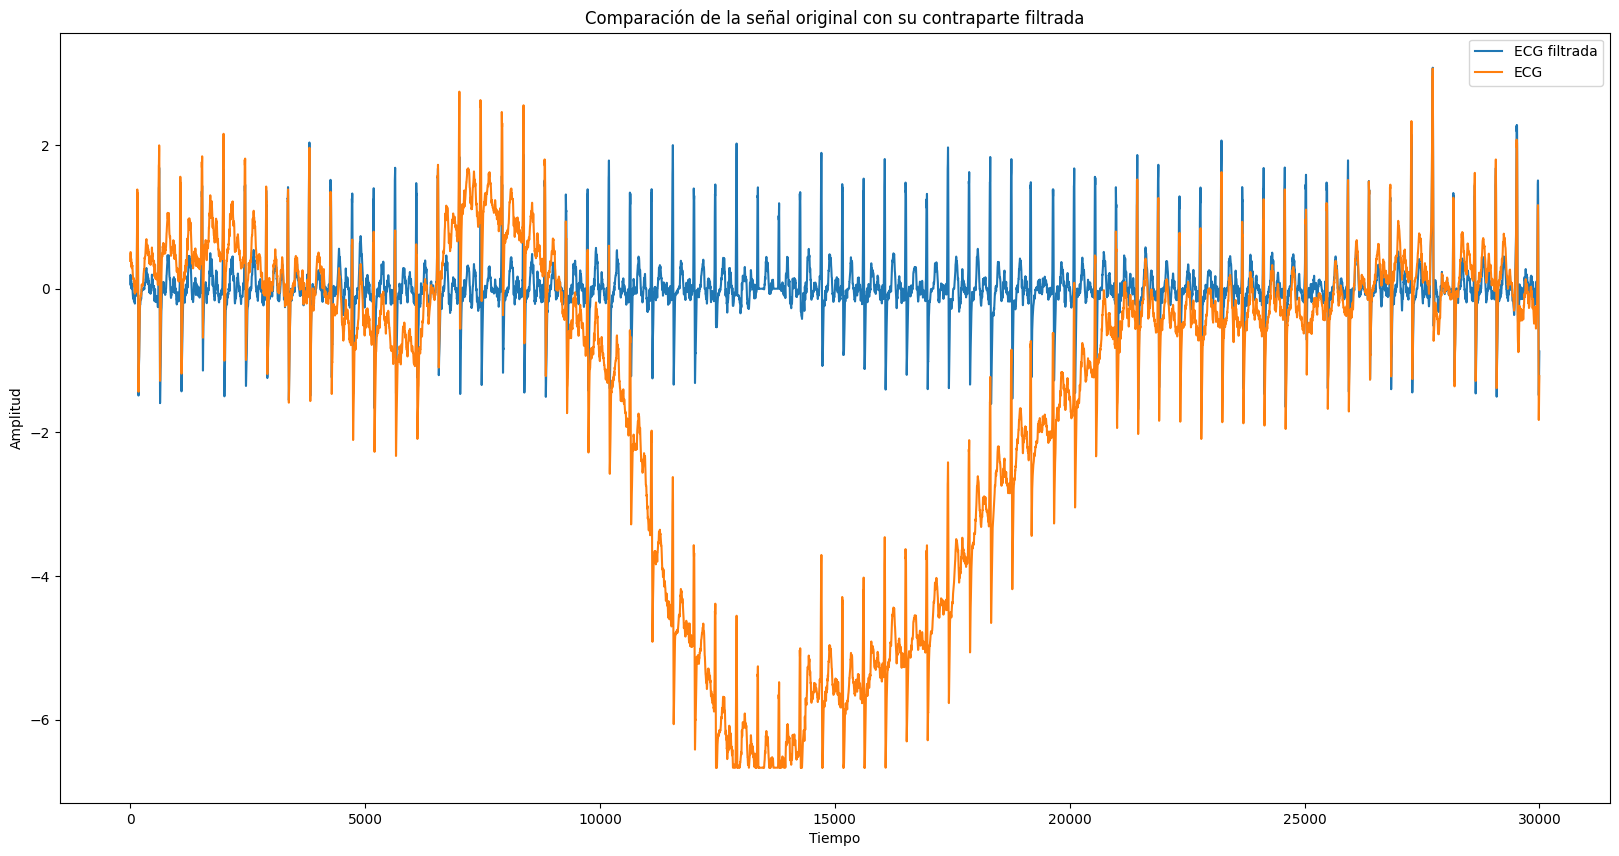

In [5]:
print("\nMediana - primeros valores de x̂ (filtrada), s (original) y b̂ (línea base):\n")

print(f"{'Índice':>6} |   {'x̂ (Filtrada)':^15}|  {'s (Original)':^15}|    {'b̂ (Línea de base)'}")
print("-" * 65)

# Mostrar los primeros 20 valores
for i in range(20):
    print(f"{i:6d} | {ecg_filt_med[i]:15.3f} | {ecg_signal[i]:15.3f} | {ecg_med2[i]:20.3f}")

plt.figure(figsize=(20,10))
plt.plot(ecg_filt_med[720000:750000], label = 'ECG filtrada')
plt.plot(ecg_signal[720000:750000], label = 'ECG')
plt.xlabel('Tiempo')
plt.ylabel('Amplitud')
plt.title('Comparación de la señal original con su contraparte filtrada')
plt.legend()
plt.show()

## Spline cúbico

In [6]:
N_ecg = len(ecg_one_lead)
t_ecg = np.arange(N_ecg) / fs_ecg  # eje de tiempo en segundos


def estimate_baseline_spline(ecg_sig, qrs_det, fs, n0_ms, window_ms):
     
    n0 = int(n0_ms * fs / 1000)          # conversión ms a muestras
    window = int(window_ms * fs / 1000)  # ventana en muestras
    
    t_ecg = np.arange(len(ecg_sig)) / fs
    baseline_times = [] #tiempos de los puntos fiduciales usados para la spline
    baseline_values = [] #valores promedio en esos puntos

    for qrs in qrs_det:
        idx = qrs - n0
        if idx - window//2 < 0 or idx + window//2 >= len(ecg_sig):
            continue  # evitamos salirnos del vector

        window_data = ecg_signal[idx - window//2 : idx + window//2]
        baseline_times.append(t_ecg[idx])
        baseline_values.append(np.mean(window_data))
        
    spline_func = interpolate.CubicSpline(baseline_times, baseline_values)
    baseline = spline_func(t_ecg) #línea de base interpolada
    return baseline, baseline_times, baseline_values

# Estimamos línea de base usando spline cúbica
baseline_full, base_times, base_vals = estimate_baseline_spline(ecg_signal, qrs_det, fs=fs_ecg, n0_ms=100, window_ms=20) #Estima la línea de base de una señal ECG usando spline cúbica
ecg_clean_full = ecg_signal - baseline_full



Mediana - primeros valores de x̂ (filtrada), s (original) y b̂ (línea base):

Índice |    x̂ (Filtrada) |   s (Original)  |    b̂ (Línea de base)
-----------------------------------------------------------------
     0 |           0.854 |          -0.155 |               -1.009
     1 |           0.827 |          -0.180 |               -1.008
     2 |           0.801 |          -0.207 |               -1.007
     3 |           0.775 |          -0.232 |               -1.007
     4 |           0.749 |          -0.257 |               -1.006
     5 |           0.724 |          -0.282 |               -1.006
     6 |           0.699 |          -0.306 |               -1.005
     7 |           0.673 |          -0.331 |               -1.004
     8 |           0.646 |          -0.357 |               -1.004
     9 |           0.620 |          -0.384 |               -1.003
    10 |           0.594 |          -0.408 |               -1.003
    11 |           0.571 |          -0.431 |               -1

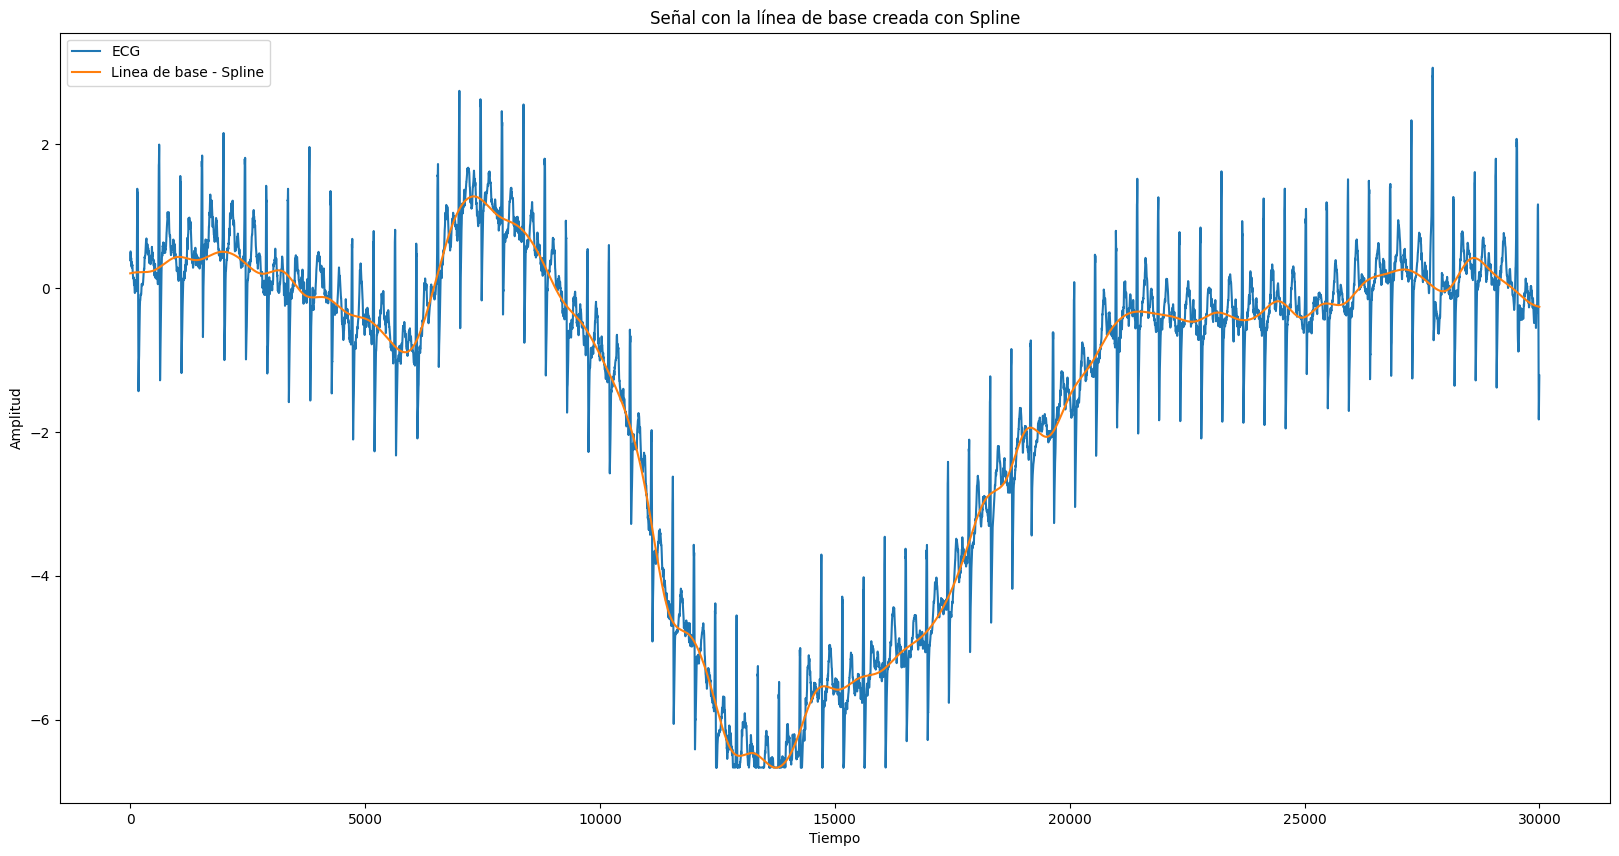

In [7]:
print("\nMediana - primeros valores de x̂ (filtrada), s (original) y b̂ (línea base):\n")

print(f"{'Índice':>6} |   {'x̂ (Filtrada)':^15}|  {'s (Original)':^15}|    {'b̂ (Línea de base)'}")
print("-" * 65)

# Mostrar los primeros 20 valores
for i in range(20):
    print(f"{i:6d} | {ecg_clean_full[i]:15.3f} | {ecg_signal[i]:15.3f} | {baseline_full[i]:20.3f}")

plt.figure(figsize=(20,10))
plt.plot(ecg_signal[720000:750000], label = 'ECG')
plt.plot(baseline_full[720000:750000], label = 'Linea de base - Spline')
plt.xlabel('Tiempo')
plt.ylabel('Amplitud')
plt.title('Señal con la línea de base creada con Spline')
plt.legend()
plt.show()

## Analisis filtros

En la tabla de los resultados obtenidos por el filtro de mediana, se observa que las estimaciones son practicamente iguales a la señal original. Como consecuencia, la señal generalizada tiende a cero en todo el segmento de análisis.

Esto conlleva a una eliminación total del contenido de la señal, algo que puede ser buscado para zonas fisiológicamente planas, pero representa un riesgo en regiones con actividad eléctrica relevante, donde podría perderse información importante de la señal.

En contraposición, al aplicar interpolación por spline cúbico, se obtiene una línea de base constante, la cual no se ajusta punto a punto a la señal original, sino que captura la tendencia general del segmento. El producto final de este comportamiento es una señal filtrada que conserva las amplitudes significativas y variaciones que podrian contener información fisiológica. Así, el spline suaviza sin eliminar información en demacía de la señal, proporcionando una estimación más balanceada de la línea base.

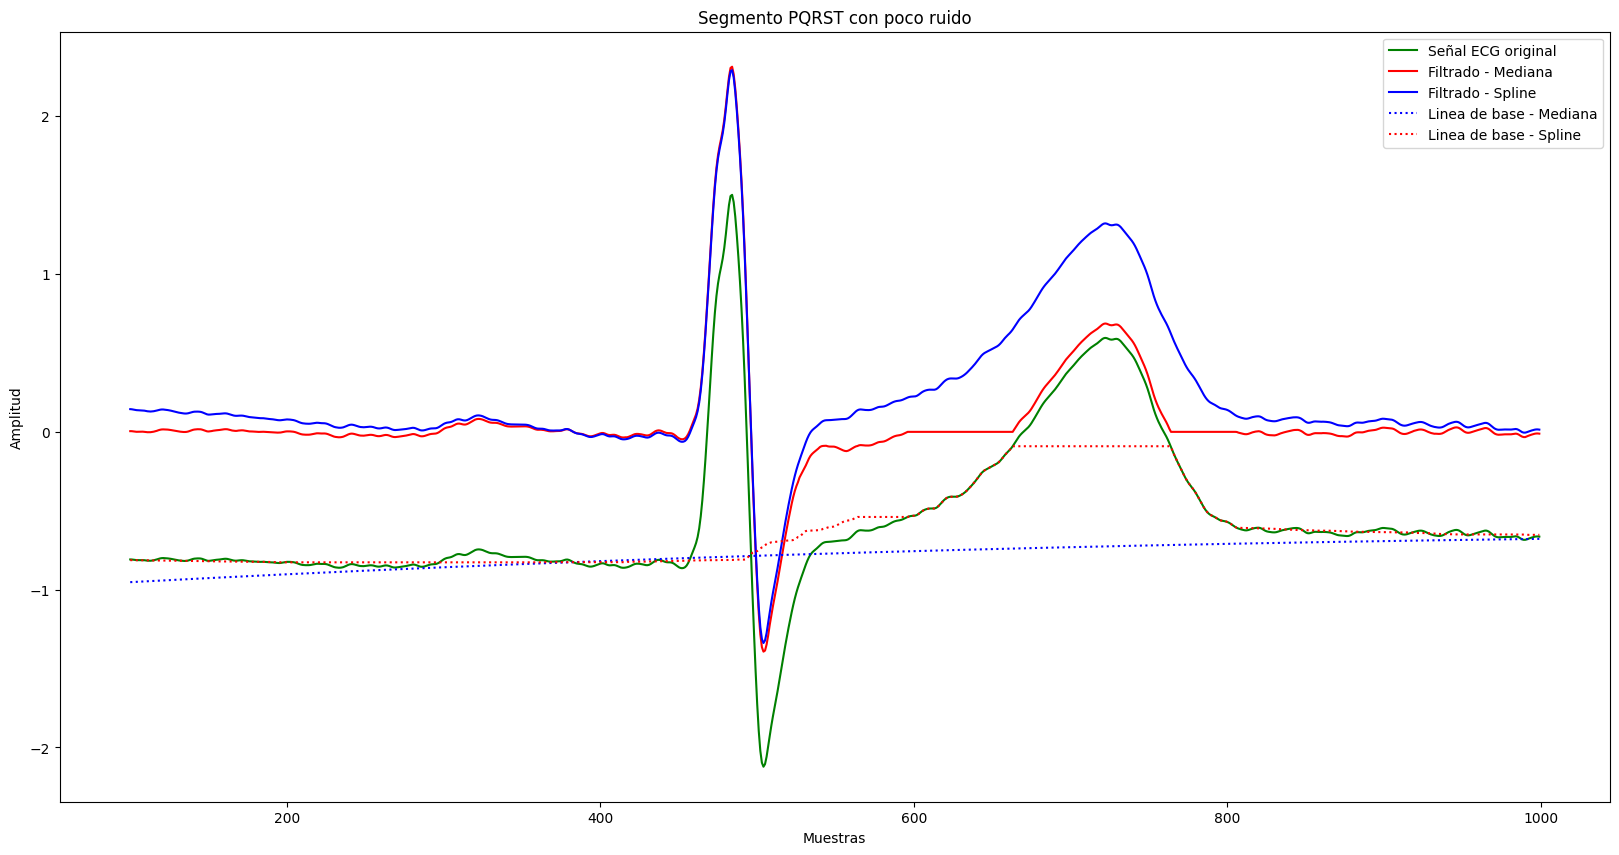

In [44]:
rango = np.arange(100,1000,1)

plt.figure(figsize=(20,10))
plt.plot(rango, ecg_signal[rango], color = 'green', label = 'Señal ECG original')
plt.plot(rango, ecg_filt_med[rango], color = 'red', label = 'Filtrado - Mediana')
plt.plot(rango, ecg_clean_full[rango], color = 'blue', label = 'Filtrado - Spline')
plt.plot(rango, baseline_full[rango], color = 'blue', linestyle = 'dotted', label = 'Linea de base - Mediana')
plt.plot(rango, ecg_med2[rango], linestyle = 'dotted', color = 'red', label = 'Linea de base - Spline')
plt.title('Segmento PQRST con poco ruido')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.legend()
plt.show()

Como se observa en el gráfico, ambos filtros se comportan de forma similar y adecuada en un segmento QRS normal, con poco ruido. En las zonas especialmente con poco ruido eléctrico, como puede el segmento entre la onda P y el comienzo del QRS, los dos filtros tienen comportamientos casi idénticos. Sin embargo, al alejarse de estas zonas, comienzan a aperecer discrepancias entre las respuestas. Por el ejemplo, la aproximación por filtro de mediana, en la zona de la onda P, parece cambiar la morfología de la señal ECG original, "planchando" la representación a 0, eliminando en el proceso lo que podría tratarse de información de la señal original. El filtro de Splines Cúbicos, en la misma sección, respeta la inclinación y morfología de la señal base, al tiempo que la orienta en torno a la línea de base que calculó.

Sin embargo, en donde se hayan distinciones más groseras es en el segmento de la onda T. En este caso, se realzan todavía más las diferencias antes mencionadas. El filtro de mediana, como se observa en la linea media que calculó y en el resultado del filtrado, cambia completamente la forma de la señal original. Mientras tanto, el filtro de Splines Cúbicos parece haber hecho un mejor trabajo en obtener la línea de base y respetar la información de la señal original.

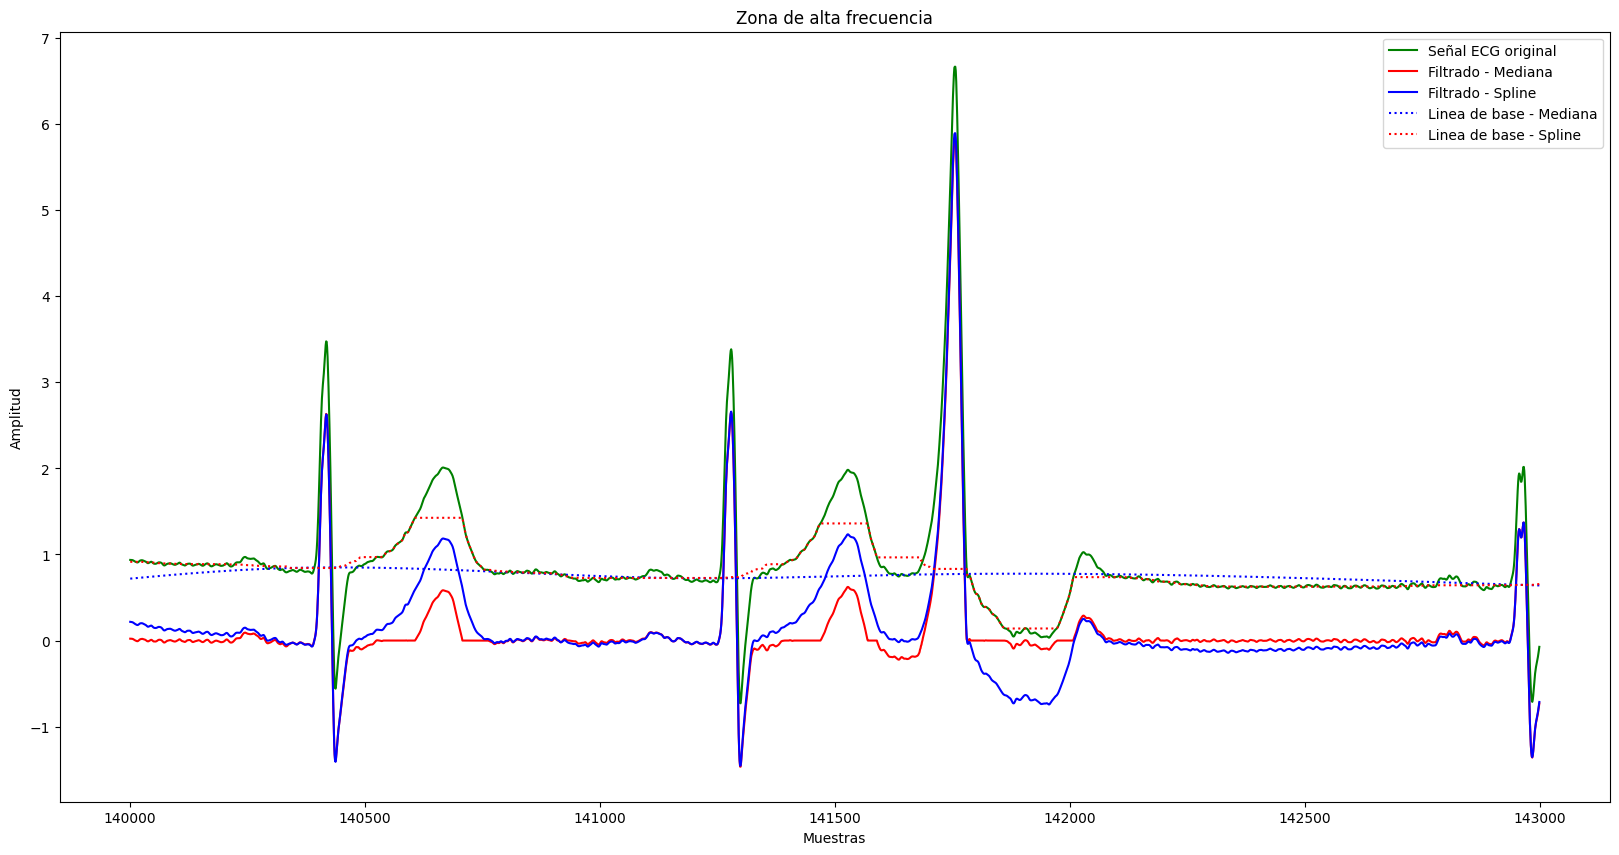

In [43]:
rango = np.arange(140000,143000,1)

plt.figure(figsize=(20,10))
plt.plot(rango, ecg_signal[rango], color = 'green', label = 'Señal ECG original')
plt.plot(rango, ecg_filt_med[rango], color = 'red', label = 'Filtrado - Mediana')
plt.plot(rango, ecg_clean_full[rango], color = 'blue', label = 'Filtrado - Spline')
plt.plot(rango, baseline_full[rango], color = 'blue', linestyle = 'dotted', label = 'Linea de base - Mediana')
plt.plot(rango, ecg_med2[rango], linestyle = 'dotted', color = 'red', label = 'Linea de base - Spline')
plt.title('Zona de alta frecuencia')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.legend()
plt.show()

En este caso, se realiza un análisis sobre un segmento de mayor frecuencia, donde los picos son más pronunciados y los latidos más cercanos entre sí. Es posible apreciar las mismas distinciones que se mencionaron en el párrafo anterior. Incluso son más notorios dichos efectos, como se aprecia en la zona del 3er latido donde hay un periodo de recuperación; la representación del filtro de mediana elimina por completo esa información, mientras que el de Spline Cúbicos mantiene la morfología de esa parte.

Estas distinciones y aparente superioridad por parte de los Splines Cúbicos frente a la mediana, debe su origen a la forma en la que ambos estiman la línea de base. Por un lado, el Spline Cúbico es un método de interpolación suave, que emplea para su confección puntos de anclaje fisiológicos. Además, garantiza continuidad hasta en la segunda derivada, lo que lo convierte en un excelente candidato para modelar oscilaciones lentas sin introducir distorisiones, como ocurre en el segmento T.

Por su parte, el filtro de mediana es fuertemente dependiente de ventanas móviles, por lo que no tiene en cuenta la morfología o el tipo de información que pudiera poseer la señal original. Todo esto, produce inconsistencias y puede generar discontinuidades (escalones) como los observados.

En relación a respuestas muy abruptas y pronunciadas, como son algunos complejos QRS, se observa como el filtro de mediana es capaz de conseguir capturar "la punta" de la señal con un poco más de precisión. Esto se debe nuevamente a sus diferencias en su aproximación a los métodos de estimación; los splines tienden a suavisar mientras que las ventanas de la mediana capturan mejor esas "angulosidades" de la señal. Por ello, las primeras, se comportan mejor en zonas lentas, donde el suavizado es visto como una ventaja. Sin embargo, en zonas de cambios rapidos como los picos del QRS, ese redondeo se lleva consigo parte de la información original de la señal.

## Filtro adaptado

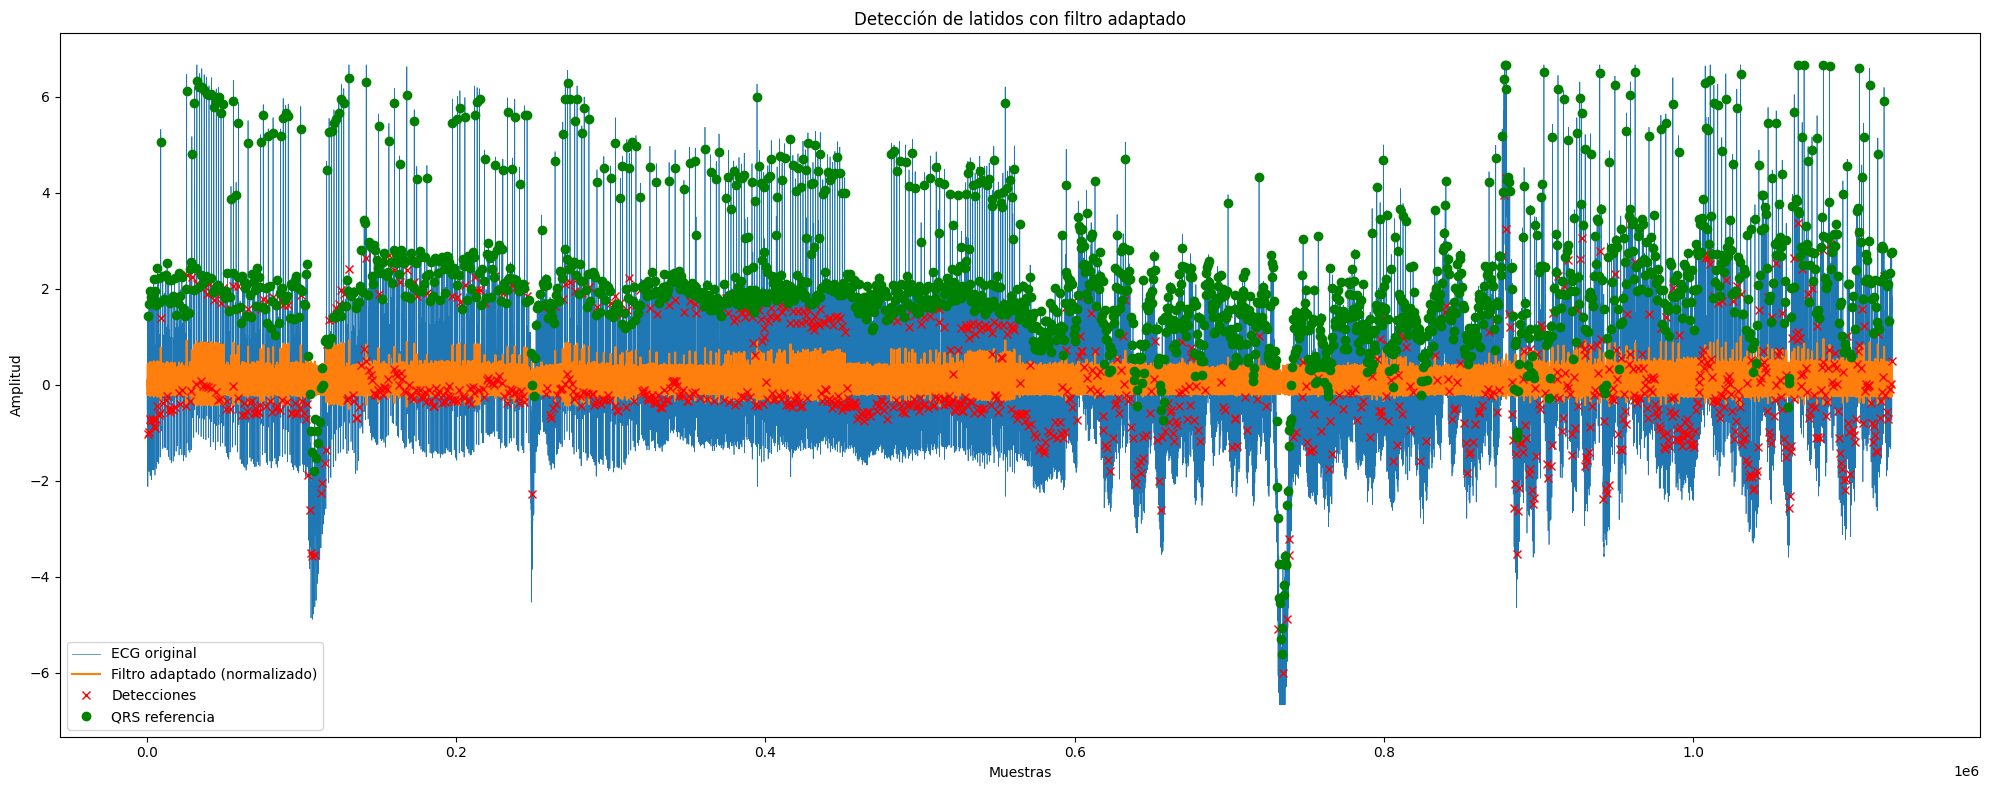

In [8]:
# Centrar señal y patrón para eliminar defasaje
ecg_centered = ecg_signal - np.mean(ecg_signal)
pattern_centered = qrs_pattern[::-1] - np.mean(qrs_pattern)

# Matched filter
filtered_signal = np.convolve(ecg_centered, pattern_centered, mode='same')

#  Detección de picos en señal filtrada 
height_threshold = np.max(filtered_signal) * 0.4
distance_threshold = int(fs_ecg * 0.3)
peaks, _ = sig.find_peaks(filtered_signal, height=height_threshold, distance=distance_threshold)

# Comparación detección con referencia
tolerance = int(0.05 * fs_ecg)
TP = 0 #True Positive
FP = 0 #False Positive

detected = np.zeros(len(qrs_det), dtype=bool)

for p in peaks:
    match = False
    for i, qrs in enumerate(qrs_det):
        if not detected[i] and abs(p - qrs) <= tolerance:
            TP += 1
            detected[i] = True
            match = True
            break
    if not match:
        FP += 1

FN = len(qrs_det) - TP
sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
precision = TP / (TP + FP) if (TP + FP) > 0 else 0

#  Resultados detección 
plt.figure(figsize=(20, 8))
plt.plot(ecg_signal, label='ECG original', linewidth=0.5)
plt.plot(filtered_signal / np.max(filtered_signal), label='Filtro adaptado (normalizado)')
plt.plot(peaks, ecg_signal[peaks], 'rx', label='Detecciones')
plt.plot(qrs_det, ecg_signal[qrs_det], 'go', label='QRS referencia')
plt.legend()
plt.title("Detección de latidos con filtro adaptado")
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.tight_layout()
plt.show()

### a)

El filtro adaptado se aprovecha de correlacionar una señal retardada conocida, que haría la función de plantilla, con una señal que se desconoce, a fin de detectar la presencia de los patrones caracteristicos de la primera, la "plantilla". Esto es el equivalente a convolucionar esa señal desconocida con una version conjugada e invertida en el tiempo de esa plantilla. En última instancia, se logra maximizar la relacion señal-ruido (SNR) en presencia de ruido estocastico aditivo.
En el caso concreto que nos compete, qrs_pattern, contiene esa "plantilla" con la forma típica del complejo QRS del ECG. Así, al aplicar el filtro adaptado sobre la señal, se consigue realzar dichos lugares y facilitar la detección de los picos.

Sin embargo, debido a las varaiciones que se pueden presentar en el complejo QRS, por un incremento de actividad o condiciones adversas de la persona, el patron de qrs_pattern podría no servirnos o jugarnos en contra.

### b)

In [9]:
print(f"Verdaderos positivos: {TP}")
print(f"Falsos positivos: {FP}")
print(f"Falsos negativos: {FN}")
print(f"Sensibilidad: {sensitivity*100:.2f}%")
print(f"Precisión: {precision*100:.2f}%")

Verdaderos positivos: 1147
Falsos positivos: 0
Falsos negativos: 756
Sensibilidad: 60.27%
Precisión: 100.00%


## Conclusiones

### Spline Cúbico vs Filtro de Mediana

Con esta experiencia se pudo observar las diferencias en comportamientos que presentan los filtros de mediana y la interpolación por spline cúbico a la hora de estimar la línea de base en señales de ECG.

El filtro de mediana arrojó una efectividad superior frente a ruido impulsivo y a distorsiones abruptas, como las observadas en el complejo QRS. No obstante, esta misma propiedad puede ser una limitación en zonas de la señal que no son planas ni tiene cambios bruscos, ya que el giltro de mediana puede eliminar no solo el ruido sino también componentes útiles y suaves, lo que termina por afectar la calidad del procesamiento.

Por otro lado, la interpoación por spline cúbico presentó una mayor capacidad para capturar tendencias lentas y oscilaciones suaves en la línea base del ECG, ofreciendo una estimación contínua y coherente desde el punto de vista fisiológico. Al ajustarse a puntos de referencia inherentes a la señal, esta técnica logra eliminar la derivada de la línea de base de la misma sin modificarla. Sin embargo, este método flaquea en regiones con transiciones rápidas, donde la suavidad del mismo tiende a redondear y atenuar los picos, modificando la morfología original y perdiendo información que podría ser crucial.

Finalmente, la elección de uno u otro método de filtrado depende del tipo de señal con la que se vaya a trabajar y el objetivo último del procesado/análisis. La interpolación pr spline cúbico es una técnica óptima para los estudios donde se busca una línea de base fisiológicamente correctsa y se cuenta con la totalidad de la señal para un procesamiento más detallado. Por otro lado, el filtro de mediana es una solución más rápida y fácil de implementar, simple y eficiente para eliminar interferencias, en especial cunado se quiere preservar la forma de eventos eléctricos rápidos y abruptos, a costa de pagarlo sobreestimaciones o subestimaciones.

### Matched Filter

En las experiencias realizadas se vio que puede ser empleado como un detector que busca en la señal una forma conocida, como el complejo QRS. El mismo, maximiza la relación señal-ruido, realzando aquellas partes de la señal que coinciden con el patrón definido, reduciendo el impacto del ruido y otras interferencias. Esto facilita la detección de eventos como los latidos en señales que se hayan muy contaminadas o que posee elevada variabilidad.

Sin embargo, el mmismo requiere de un entendimiento y pre procesamiento de la señal a filtrar muy alto, ya que cualquier pequeña variación podria provocar un resultado erróneo o muy diferente a lo que buscamos. Por ejemplo, una mala normalización de la señal patrón o la original ó una errónea elección de los valores umbral pueden provocar en nuestro detector que ciertos puntos de la señal no sean detectados como eventos disparadores cuando sí deberían. De igual forma, un pequeño desliz en la definición de nuestro patrón puede llevar a anormalidades en el resultado esperado.

Por todo esto, a pesar de una poderosa herramienta de análisis, hay que tener presente que requiere de una atención a los detalles especialmente meticulosa, donde se debe cuidar no solo a los valores umbral y al patrón seleccionado sino también al estado de la señal original.